# Bayesian Logistic Regression

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal

In [2]:
X, y = make_blobs(n_samples=100, centers=2, n_features=2, cluster_std=2.2, random_state=20)

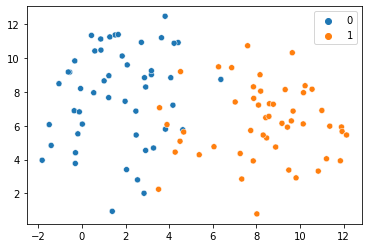

In [3]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y);

In [7]:
class BayesianLogisticRegression:
    def __init__(self, basis=None, beta:float=1.0, alpha:float=1.0, degree=None, b_mu=None, b_s=None):
        self.alpha = alpha
        self.beta = beta
        self.basis = basis
        self.degree = degree
        self.b_mu = b_mu
        self.b_s = b_s
        self.m_N = None
        self.S_N = None
        
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
        
    # get the basis of the input (Gaussian, Poly, Sigmoidal)
    def _basis(self, X):
        if isinstance(self.b_mu, int):
            self.b_mu = [self.b_mu] 
            
        X_trans = []
        if self.basis.lower()=='gauss':
            for m in self.b_mu:
                X_trans.append(np.exp(-0.5 * np.square(X - m)/self.b_s))

        elif self.basis.lower()=='poly':
            for i in range(0, self.degree+1):
                X_trans.append(X**i)

        elif self.basis.lower()=='sig':
            for m in self.b_mu:
                X_trans.append((np.tanh((X - m) / self.b_s) + 1 ) / 2)
        else:
            raise "Only Gauss, Poly, Sig"

        return np.asarray(X_trans).squeeze().transpose()

    # get a uninformative prior
    def get_prior(self, m):
        S_0 = np.eye(m) * self.alpha
        m_0 = np.zeros((m, 1))
        return S_0, m_0
        
    # fit the data to get the m_N and S_N of the posterior
    def fit(self, X, y):
        
        if self.basis:
            X = self._basis(X)
        
        self.N, self.P = X.shape
        
        # add cloumn of ones in X for the bias term
        X = np.append(X, np.ones((self.N, 1)), axis=1)
        y = y.reshape(self.N, 1)
        
        #################
        # Get the prior #
        #################
        self.S_0, self.m_0 = self.get_prior(self.P + 1)
        
        #############################
        # calculating the posterior #
        #############################
        N, D = X.shape
        # Compute the posterior over the weights
        self.S_N = np.linalg.inv(np.linalg.inv(self.S_0) + self.beta * X.T.dot(X))
        self.m_N = self.beta * self.S_N.dot(X.T).dot(y)
        # The posterior
        self.posterior = multivariate_normal(mean=self.m_N.ravel(), cov=self.S_N)

    # get the posterior predictive
    def posterior_predictive(self, X, std=False):

        if self.basis:
            X = self._basis(X)
        
        X = X.reshape(-1, self.P)
        X = np.append(X, np.ones((X.shape[0],1)), axis=1)
        
        self.P_M = self._sigmoid(X.dot(self.m_N))
        self.P_S = 1 / self.beta + np.sum(np.diag(X.reshape(1, -1).dot(self.S_N).dot(X.reshape(-1, 1))))
        post_pred = multivariate_normal(mean=self.P_M.ravel(), cov=self.P_S)
        return post_pred

    def predict(self, X, prob=False, threshold:float=0.5):
        if self.basis:
            X = self._basis(X)
        X = np.append(X, np.ones((X.shape[0], 1)), axis=1)
        probabilities = self._sigmoid(X.dot(model.m_N)).flatten()
        if prob:
            return probabilities
        return np.where(probabilities > threshold, 1, 0)

In [8]:
# Fit the model
model = BayesianLogisticRegression()
model.fit(X, y)

# Make predictions
predictions = model.predict(X)

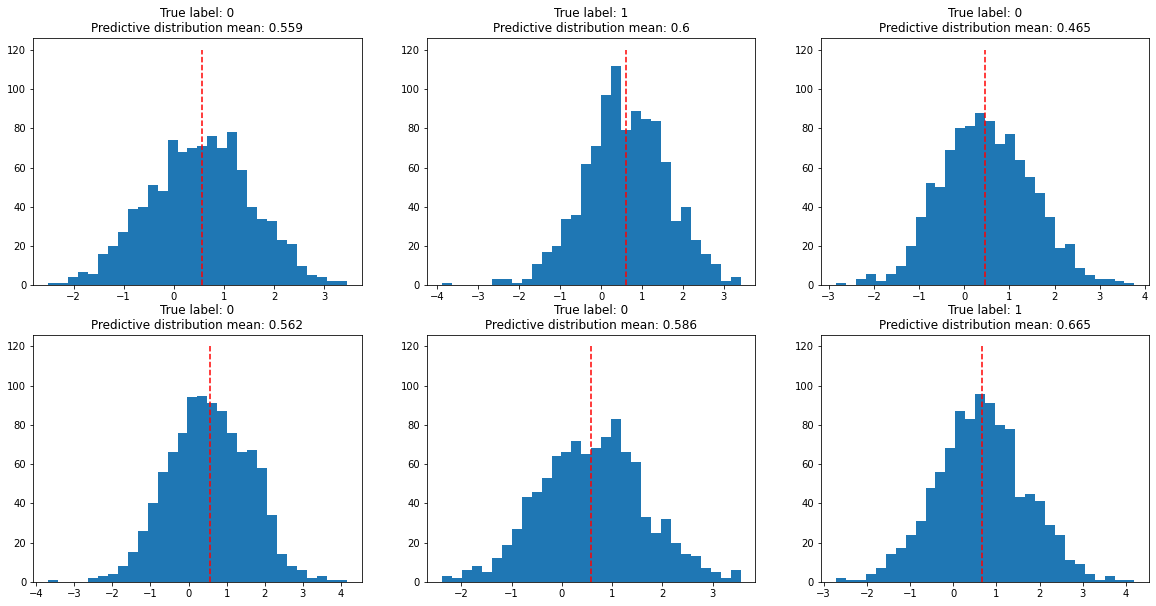

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i in range(6):
    idx = np.random.choice(range(0, len(X)), 1)[0]
    preds = model.posterior_predictive(X[idx:idx+1]).rvs(1000)
    mean = round(model.predict(X[idx:idx+1], prob=True)[0], 3)
    ax = axes[i//3][i%3]
    ax.set_title(f"True label: {y[idx]}\nPredictive distribution mean: {mean}")
    ax.hist(preds, bins=30)
    ax.vlines(x=mean, ymin=0, ymax=120, linestyles='dashed', color='r')

<!-- fig, ax = plt.subplots(1, 1)
h = 0.01
for i in range(1):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    x = np.c_[xx.ravel(), yy.ravel()]
    x = np.append(x, np.ones((x.shape[0], 1)), axis=1)

    w = model.posterior.rvs(1)
    Z = x.dot(model.m_N).reshape(xx.shape)
    
    plot_DB(X, y, model, '',  0.01, ax) 

from utils import plot_DB
for w in model.posterior.rvs(10):
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
    plot_DB();
-->
    =